# Linear Regression Model of Wind Farm Output
This notebook contains a model to predict wind farm contributions to electrical supply from time series windspeed data.



### Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Read in Windspeed Data

In [23]:
wsp1 = pd.read_csv('../datasets/time_series/wsp_output1.csv')
wsp2 = pd.read_csv('../datasets/time_series/wsp_output2.csv')
wsp = pd.concat([wsp1,wsp2],axis=0)
wsp['date'] = pd.to_datetime(wsp['date'],format='%Y-%m-%dT%H:%M:%S')
wsp.set_index('date',inplace=True)
wsp.index = pd.to_datetime(wsp.index)
print(wsp.shape)
wsp.tail(3)

(1632, 7)


,0,1,2,3,4,5,6
date,,,,,,,
2020-05-21 21:00:00,28209.12,13261.28,8942.05,2432.0,2683.8,506.0,4026.96
2020-05-21 22:00:00,28209.12,14918.94,9629.90,2736.0,2385.6,404.8,4474.40
2020-05-21 23:00:00,35261.40,14918.94,9629.90,3344.0,2683.8,303.6,4474.40


### Read in Wind Farm Output Data

In [24]:
ts = pd.read_csv('../datasets/time_series/renewables_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.tail(3)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2020-05-21 21:00:00,-3.000000,3037.583333,938.250000,347.833333,230.666667
2020-05-21 22:00:00,-3.000000,3265.083333,941.583333,341.833333,229.666667
2020-05-21 23:00:00,-3.909091,3296.090909,941.818182,338.090909,230.000000


### Merge datasets on time index

In [25]:
data = pd.merge(wsp,mwh['wind'],how='left',left_index=True, right_index=True)
print(data.shape)
data.head(3)

(1632, 8)


,0,1,2,3,4,5,6,wind
date,,,,,,,,
2020-03-15 00:00:00,28209.12,11603.62,7566.35,4256.0,2087.4,506.0,6264.16,1728.250000
2020-03-15 01:00:00,28209.12,11603.62,9629.90,4256.0,2087.4,303.6,6711.60,1464.333333
2020-03-15 02:00:00,24682.98,11603.62,8942.05,4256.0,1789.2,303.6,6711.60,1282.166667


### EDA

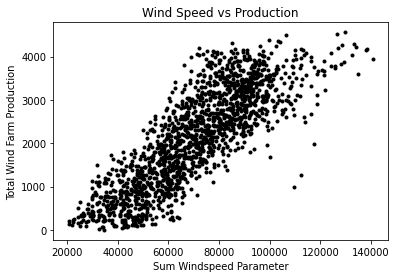

In [40]:
plt.plot(wsp.sum(axis=1),data['wind'],'k.')
plt.xlabel('Sum Windspeed Parameter')
plt.ylabel('Total Wind Farm Production')
plt.title('Wind Speed vs Production');

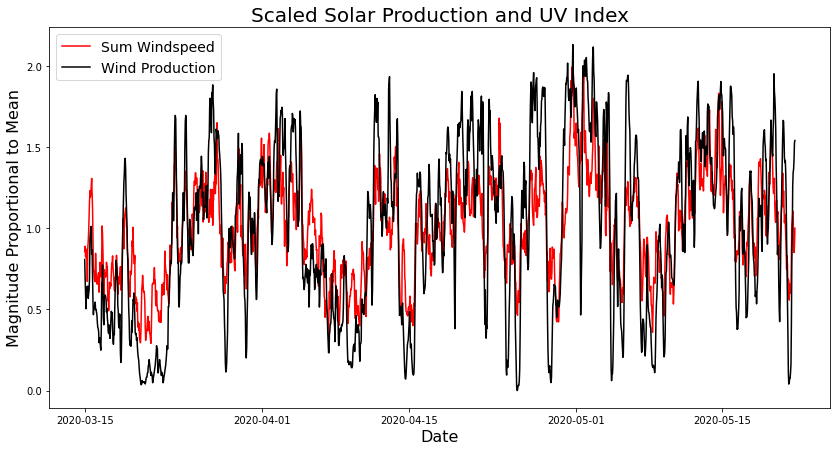

In [27]:
plt.figure(figsize=(14,7))
plt.plot(wsp.index,wsp.sum(axis=1)/np.mean(wsp.sum(axis=1)),'r-',label='Sum Windspeed')
plt.plot(wsp.index,data['wind']/np.mean(data['wind']),'k-',label='Wind Production')
plt.ylabel('Magnitude Proportional to Mean',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Scaled Solar Production and UV Index',fontsize=20)
plt.legend(loc='upper left',fontsize=14);

### Train test split

In [36]:
X = data.drop(columns='wind')
y = data['wind']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,shuffle=False)

### Fit model and generate predictions

In [37]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

### Visualize results

RMSE = 523.4321112418402


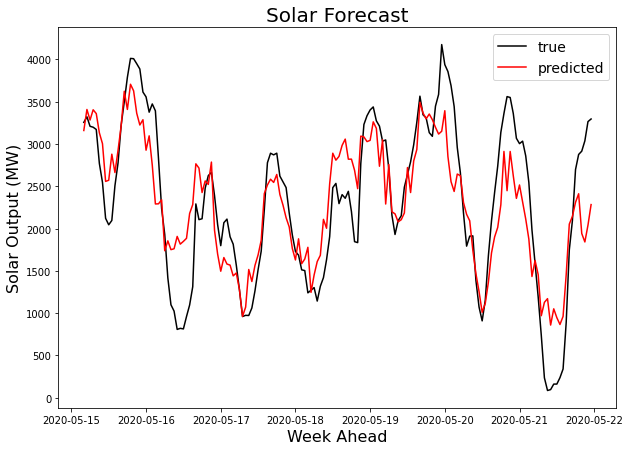

In [38]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, preds))}")
plt.figure(figsize=(10,7))
plt.plot(y_test.index,y_test,'k-',label='true')
plt.plot(y_test.index,preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Week Ahead',fontsize=16)
plt.ylabel('Solar Output (MW)',fontsize=16)
plt.title('Solar Forecast',fontsize=20);

### Write predictions to file

In [31]:
predictions = pd.DataFrame({'date':y_test.index,'wind_prediction':preds})
predictions.to_csv('../datasets/wind_prediction.csv',index=False)